# Preprocessing of Casal Montserratina Datset

In [219]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Functionalities
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

# Others
import calendar
from datetime import timedelta 
import holidays

# Parameters Dict
parameters = {
    "paths": {
        "Consumption_2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "Consumption_2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "Consumption_2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "Consumption_2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv",
        "Consumption_2024_01_05": "../data/data_casal_montserratina/Casal_Montserratina_202401_202405.csv",
        "Meteorological": "../data/data_casal_montserratina/LaMonserratina_weather_&_PV.csv",
    }
}

### Functions

In [220]:
# Plots a time series curve
def grafico_zoom(df_x, df_y, title, yaxis_title, filename):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_x, 
        y=df_y, 
        mode='lines', 
        name='Line', 
        connectgaps=False 
    ))

    fig.update_layout(
        title=title,  
        xaxis_title="Date",
        yaxis_title=yaxis_title, 
        xaxis_tickangle=0, 
        showlegend=False
    )
    # Save the image with the specified filename
    fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

In [221]:
# Checks the missing dates across all the time series dataset
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='h')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates, date_range

## Load and Prepare Datasets

In [222]:
# Load Energy Consumtion Dataset
consumption_path = "../data/data_casal_montserratina/"
df_1 = pd.read_csv(parameters["paths"]["Consumption_2022_01_06"], delimiter=";")
df_2 = pd.read_csv(parameters["paths"]["Consumption_2022_07_12"], delimiter=";")
df_3 = pd.read_csv(parameters["paths"]["Consumption_2023_01_06"], delimiter=";")
df_4 = pd.read_csv(parameters["paths"]["Consumption_2023_07_12"], delimiter=";")
df_5 = pd.read_csv(parameters["paths"]["Consumption_2024_01_05"], delimiter=";")

In [223]:
# Concatenate the 4 datasets of Electricity Consumption
df = pd.concat([df_1, df_2, df_3, df_4, df_5], ignore_index=True)
df.head()

TimeStamp  Valor  Període tarifari Tipus lectura
0  01/01/2022 00:00      6                 6          Real
1  01/01/2022 01:00      6                 6          Real
2  01/01/2022 02:00      5                 6          Real
3  01/01/2022 03:00      7                 6          Real
4  01/01/2022 04:00      7                 6          Real

In [224]:
# Clean and Drop fields
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")
df = df.drop(columns=["Tipus lectura", "Període tarifari"])
df.rename(columns={'TimeStamp': 'Date', 
                   'Valor': 'Consumo'}, inplace=True)

In [225]:
# Load Meteorolgical Dataset
df_PV = pd.read_csv(parameters["paths"]["Meteorological"])
df_PV['Date'] = pd.to_datetime(df_PV['Date'])
df_PV.set_index("Date", inplace=True)
df_PV = df_PV.resample('1H').mean()
df_PV.reset_index(inplace=True)
df_PV.head(5)

Date  temperature_2m_C  relative_humidity_2m_%  \
0 2021-01-01 00:00:00           7.76525               78.289806   
1 2021-01-01 01:00:00           6.19025               80.961248   
2 2021-01-01 02:00:00           5.15900               85.244406   
3 2021-01-01 03:00:00           5.28400               87.411388   
4 2021-01-01 04:00:00           5.04650               90.309694   

   dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
0         4.22150                5.508863       1006.487473   
1         3.15275                3.521368       1006.224976   
2         2.88400                2.378472       1005.987473   
3         3.35900                2.768215       1005.724976   
4         3.59025                2.600666       1005.524994   

   surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
0           1000.511047      39.075002              38.000   
1           1000.216370      45.225003              55.250   
2            999.958206      36.862503              84.375   
3            999.699951      44.100003              82.375   
4            999.496155      44.512501              64.500   

   et0_fao_evapotranspiration_mm  ...  is_day  sunshine_duration_sec  \
0                       0.000576  ...     0.0                    0.0   
1                       0.000967  ...     0.0                    0.0   
2                       0.000011  ...     0.0                    0.0   
3                       0.000000  ...     0.0                    0.0   
4                       0.000000  ...     0.0                    0.0   

   shortwave_radiation_W/m2  direct_radiation_W/m2  diffuse_radiation_W/m2  \
0                       0.0                    0.0                     0.0   
1                       0.0                    0.0                     0.0   
2                       0.0                    0.0                     0.0   
3                       0.0                    0.0                     0.0   
4                       0.0                    0.0                     0.0   

   direct_normal_irradiance_W/m2  global_tilted_irradiance_W/m2  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   

   terrestrial_radiation_W/m2  Temp_interna_Modulo_C  PV_kW  
0                         0.0              20.740545    0.0  
1                         0.0              20.029105    0.0  
2                         0.0              19.563281    0.0  
3                         0.0              19.619745    0.0  
4                         0.0              19.512464    0.0  

[5 rows x 24 columns]

### Merge Datasets

In [226]:
# Setting Date as Index for merging and then reset it
df.set_index("Date", inplace=True)
df_PV.set_index("Date", inplace=True)
merged_df = df.merge(df_PV, how="inner", on="Date")
merged_df.reset_index(inplace=True)
merged_df.head(2)

Date  Consumo  temperature_2m_C  relative_humidity_2m_%  \
0 2022-01-01 00:00:00        6           7.79025               90.588577   
1 2022-01-01 01:00:00        6           7.28400               89.860893   

   dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
0         6.34650                5.897182       1027.949951   
1         5.72775                5.195249       1027.549988   

   surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  ...  is_day  \
0           1021.846619      50.512499                 0.0  ...     0.0   
1           1021.438141      18.562499                 0.0  ...     0.0   

   sunshine_duration_sec  shortwave_radiation_W/m2  direct_radiation_W/m2  \
0                    0.0                       0.0                    0.0   
1                    0.0                       0.0                    0.0   

   diffuse_radiation_W/m2  direct_normal_irradiance_W/m2  \
0                     0.0                            0.0   
1                     0.0                            0.0   

   global_tilted_irradiance_W/m2  terrestrial_radiation_W/m2  \
0                            0.0                         0.0   
1                            0.0                         0.0   

   Temp_interna_Modulo_C  PV_kW  
0              20.751838    0.0  
1              20.523160    0.0  

[2 rows x 25 columns]

### Calculating Demand = Consumption + Photovoltaic Generation

In [227]:
# Demanda_kWh will be our target variable
merged_df["Demanda_kWh"] = merged_df["Consumo"] + merged_df["PV_kW"]
merged_df = merged_df.drop(columns=["Consumo", "PV_kW"], axis=1)

## Process and Clean Datasets

### Missing Values

In [228]:
# Checking NaNs and Missing Values
print(f"NaN Count per Column", merged_df.isna().any(axis=1).sum())
missing_dates, date_range = checkMissingData(merged_df, 'Date')

NaN Count per Column 0
Number of Missing Values: 2906


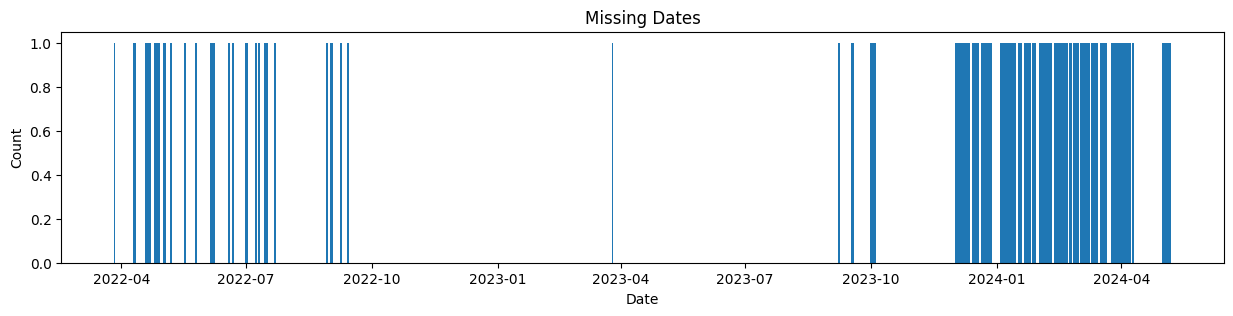

In [229]:
plt.figure(figsize=(15, 3))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")
plt.savefig("../results/missing_dates.png", bbox_inches='tight', dpi=300)
plt.show()

### Fill the Empty Spaces

In [230]:
# Drop duplicates
merged_df = merged_df.drop_duplicates(keep=False)
merged_df.set_index("Date", inplace=True)

# Reindex the Dataset filling all the empty spaces with NaNs
merged_df = merged_df.reindex(date_range)

merged_df.reset_index(inplace=True)
merged_df.rename(columns={'index': 'Date'}, inplace=True) 
missing_dates, date_range = checkMissingData(merged_df, 'Date')

Number of Missing Values: 0


In [231]:
grafico_zoom(merged_df["Date"], merged_df["Demanda_kWh"],
              "Consumo Eléctrico - Casal La Monserratina", "Consumo [kWh]", filename="curva_demanda_original")

### NaNs Assignment

1       4
24     28
48      7
72      6
96      7
120     4
144     1
168     1
Name: count, dtype: int64


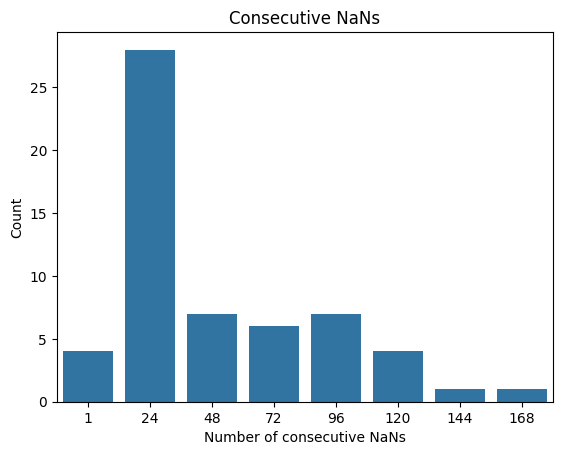

In [232]:
# Plot the Count of the Consecutive NaN Gaps
def plot_consecutive_nans(df, column):
    sr = df[column]
    nans = sr.isna()
    consecutive_nans = []
    count = 0

    for nan in nans:
        if nan:
            count += 1
        elif count > 0:
            consecutive_nans.append(count)
            count = 0
    
    if count > 0:
        consecutive_nans.append(count)

    count_series = pd.Series(consecutive_nans).value_counts().sort_index()
    print(count_series)

    ax = sns.barplot(x=count_series.index, y=count_series.values)
    ax.set_title('Consecutive NaNs')
    ax.set_xlabel('Number of consecutive NaNs')
    ax.set_ylabel('Count')

    plt.show()

plot_consecutive_nans(merged_df, "Demanda_kWh")

In [233]:
# Fill the gaps that are contained in a gap that has X consecutive NaNs
def fillGaps(df, max_gap=24):
    new_df = df.copy(deep=True)
    is_null = new_df["Demanda_kWh"].isnull()
    null_groups = (is_null != is_null.shift()).cumsum()
    group_sizes = is_null.groupby(null_groups).sum()
    valid_groups = group_sizes[group_sizes <= max_gap].index
    valid_mask = null_groups.isin(valid_groups) & is_null
    filtered_df = new_df[valid_mask].copy(deep=True)

    #1 Week
    filtered_df["Demand_1w_before"] = new_df["Demanda_kWh"].shift(periods=24*7).fillna(0)
    #2 Week
    filtered_df["Demand_2w_before"] = new_df["Demanda_kWh"].shift(periods=24*14).fillna(0)
    #3 Week
    filtered_df["Demand_1w_after"] = new_df["Demanda_kWh"].shift(periods=-24*7).fillna(0)
    #4 Week
    filtered_df["Demand_2w_after"] = new_df["Demanda_kWh"].shift(periods=-24*14).fillna(0)
    #Mean
    consumo_4w_mean = (filtered_df["Demand_1w_before"] + filtered_df["Demand_1w_after"] + filtered_df["Demand_2w_before"] + filtered_df["Demand_2w_after"]) / 4
    
    filtered_df['shifted_demand'] = consumo_4w_mean[filtered_df.index]
    return filtered_df

filtered_df = fillGaps(merged_df)
merged_df.loc[filtered_df.index, 'Demanda_kWh'] = filtered_df['shifted_demand']

48     7
72     6
96     7
120    4
144    1
168    1
Name: count, dtype: int64


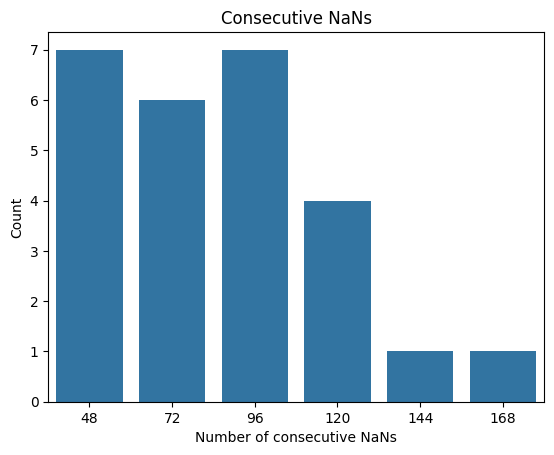

In [234]:
plot_consecutive_nans(merged_df, "Demanda_kWh")

In [235]:
def slicer_grafico(df, fecha_inicial, fecha_final, title, yaxis_title, filename=None):
    df_descarte = df.copy(deep=True)

    # Dividir los datos en dos partes
    df_1 = df_descarte[df_descarte.Date <= pd.to_datetime(fecha_final)]
    df_1 = df_1[df_1.Date >= pd.to_datetime(fecha_inicial)]
    df_2 = df_descarte[len(df_1):]

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_descarte.Date, 
        y=df_descarte.Demanda_kWh, 
        mode='lines', 
        name='Parte del dataset que se descarta', 
        connectgaps=False,
        line=dict(color='lightgrey')  # Color gris claro
    ))
    fig.add_trace(go.Scatter(
        x=df_1.Date, 
        y=df_1.Demanda_kWh, 
        mode='lines', 
        name='Parte del dataset que se utilizará', 
        connectgaps=False,
        line=dict(color='blue')  # Color azul
    ))
    fig.update_layout(
            title=title,  
            xaxis_title="Date",
            yaxis_title=yaxis_title, 
            xaxis_tickangle=0, 
            legend=dict(
                x=0.74,
                y=0.98,
                bgcolor='rgba(255, 255, 255, 0.5)',
                bordercolor='rgba(0, 0, 0, 0.5)',
                borderwidth=1
            )
    )
    # Guardar la imagen en el archivo especificado
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", format="png", width=1000, scale=2)
    fig.show()
    
slicer_grafico(merged_df, 
    "2022-07-02 00:00:00",  # Fecha inicial
    "2023-11-30 23:00:00",  # Fecha final
    title="Bounded Electricity Demand", 
    yaxis_title="Demand [kWh]",
    filename="DemandaDescartada")

Due to the quantity of null values at the end of the dataset, the last 5 months of Demand Data is discarded. It is also discarded the first 6 months of the data, because they contain very different values from the rest of the dataset. If there are more NaN values, they are dropped.

In [236]:
merged_df.dropna(inplace=True)
merged_df['Demanda_kWh'] = merged_df['Demanda_kWh'].apply(lambda x: 2.0 if x < 2 else x)


In [237]:
merged_df.isnull().any()

Date                             False
temperature_2m_C                 False
relative_humidity_2m_%           False
dew_point_2m_C                   False
apparent_temperature_C           False
pressure_msl_hPa                 False
surface_pressure_hPa             False
cloud_cover_%                    False
cloud_cover_high_%               False
et0_fao_evapotranspiration_mm    False
vapour_pressure_deficit_kPa      False
wind_speed_10m_km/h              False
wind_direction_10m_º             False
wind_gusts_10m                   False
is_day                           False
sunshine_duration_sec            False
shortwave_radiation_W/m2         False
direct_radiation_W/m2            False
diffuse_radiation_W/m2           False
direct_normal_irradiance_W/m2    False
global_tilted_irradiance_W/m2    False
terrestrial_radiation_W/m2       False
Temp_interna_Modulo_C            False
Demanda_kWh                      False
dtype: bool

We also have established 2kWh as the minimum value for the Demand, since a value of 0 kWh is impossible to occur, because the are devices that need energy to mantain their basic functionality. The value of kWh seems to be the lower boundary in the first 6 months of data.

### Slice Dataset

In [238]:
# Define start and end dates - 'YYYY-MM-DD HH:MM:SS'.
start_date = '2022-07-02 00:00:00'
end_date = '2023-11-30 23:00:00'

merged_df = merged_df.loc[(merged_df.Date >= pd.to_datetime(start_date, format='%Y-%m-%d %H:%M:%S'))]
merged_df = merged_df.loc[(merged_df.Date <= pd.to_datetime(end_date, format='%Y-%m-%d %H:%M:%S'))]

grafico_zoom(merged_df["Date"], merged_df["Demanda_kWh"],
              "Bounded Electricity Demand Dataset", "Demand [kWh]", filename="curva_demanda_acotada")

In [239]:
q1 = merged_df["Demanda_kWh"].quantile(0.25)
q3 = merged_df["Demanda_kWh"].quantile(0.75)
iqr = q3 - q1

#Calculate the lower abnd upper limits to identify the outliers
lim_inf = q1 - (1.5 * iqr)
lim_sup = q3 + (1.5 * iqr)

outliers = ((merged_df["Demanda_kWh"] < lim_inf) | (merged_df["Demanda_kWh"] > lim_sup))
print(f"The Number of Outliers is {outliers.sum()}. The limits are {lim_inf} and {lim_sup}.\n")

The Number of Outliers is 1023. The limits are -4.246827624999999 and 12.411379375.



In [240]:
def winsorizeData(df, columns, upper_bound, lower_bound):
    for col in columns:
        min_value = df[col].quantile(lower_bound)
        max_value = df[col].quantile(upper_bound)
        df[col] = df[col].clip(lower=min_value, upper=max_value)

columnswOutliers = ["Demanda_kWh"]
winsorizeData(merged_df, columnswOutliers, 0.95, 0.0)

### Outliers of Demand

In [241]:
q1 = merged_df["Demanda_kWh"].quantile(0.25)
q3 = merged_df["Demanda_kWh"].quantile(0.75)
iqr = q3 - q1

#Calculate the lower abnd upper limits to identify the outliers
lim_inf = q1 - (1.5 * iqr)
lim_sup = q3 + (1.5 * iqr)

outliers = ((merged_df["Demanda_kWh"] < lim_inf) | (merged_df["Demanda_kWh"] > lim_sup))
print(f"The Number of Outliers is {outliers.sum()}. The limits are {lim_inf} and {lim_sup}.\n")

The Number of Outliers is 1023. The limits are -4.246827624999999 and 12.411379375.



This means that values above 12.41 are considered Outliers using this methodology

### Histogram

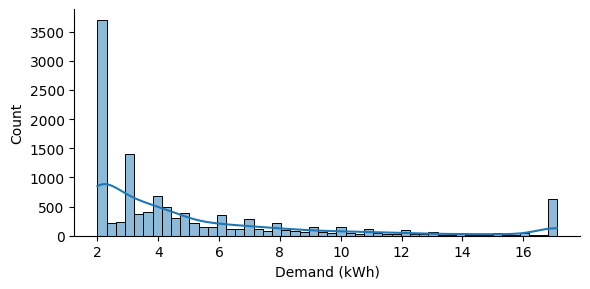

In [242]:
fg = sns.displot(merged_df['Demanda_kWh'], height=3, aspect= 2, bins=50, kde=True)
fg.set_axis_labels("Demand (kWh)", "Count")
fg.savefig("../results/histograma_original.png", bbox_inches='tight', dpi=300)

In [243]:
merged_df[["Demanda_kWh"]].describe()

Demanda_kWh
count  12069.000000
mean       5.140892
std        4.105534
min        2.000000
25%        2.000000
50%        3.591124
75%        6.164552
max       17.108163

The histogram of the Demand is very skewed to the left, 

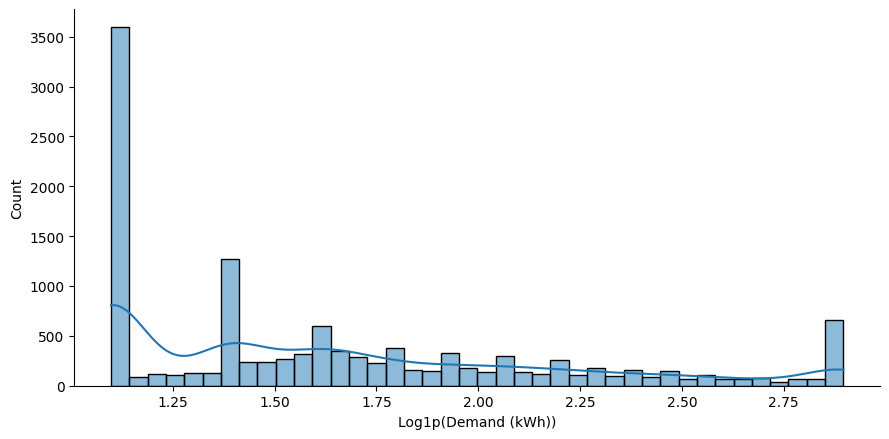

In [244]:
log_df = merged_df.copy(deep=True)
log_df["Demanda_kWh_log"] = np.log1p(log_df["Demanda_kWh"])
fg = sns.displot(log_df['Demanda_kWh_log'], height=4.5, aspect= 2, bins=40, kde=True)
fg.set_axis_labels("Log1p(Demand (kWh))", "Count")
fg.savefig("../results/log_histogram.png", bbox_inches='tight', dpi=300)

In [245]:
q1 = log_df["Demanda_kWh_log"].quantile(0.25)
q3 = log_df["Demanda_kWh_log"].quantile(0.75)
iqr = q3 - q1

#Calculate the lower abnd upper limits to identify the outliers
lim_inf = q1 - (1.5 * iqr)
lim_sup = q3 + (1.5 * iqr)

outliers = ((log_df["Demanda_kWh_log"] < lim_inf) | (log_df["Demanda_kWh_log"] > lim_sup))
print(f"The Number of Outliers is {outliers.sum()}. The limits are {lim_inf} and {lim_sup}.\n")

The Number of Outliers is 0. The limits are -0.20718752572332355 and 3.274945312653832.



## Dataset Decomposition

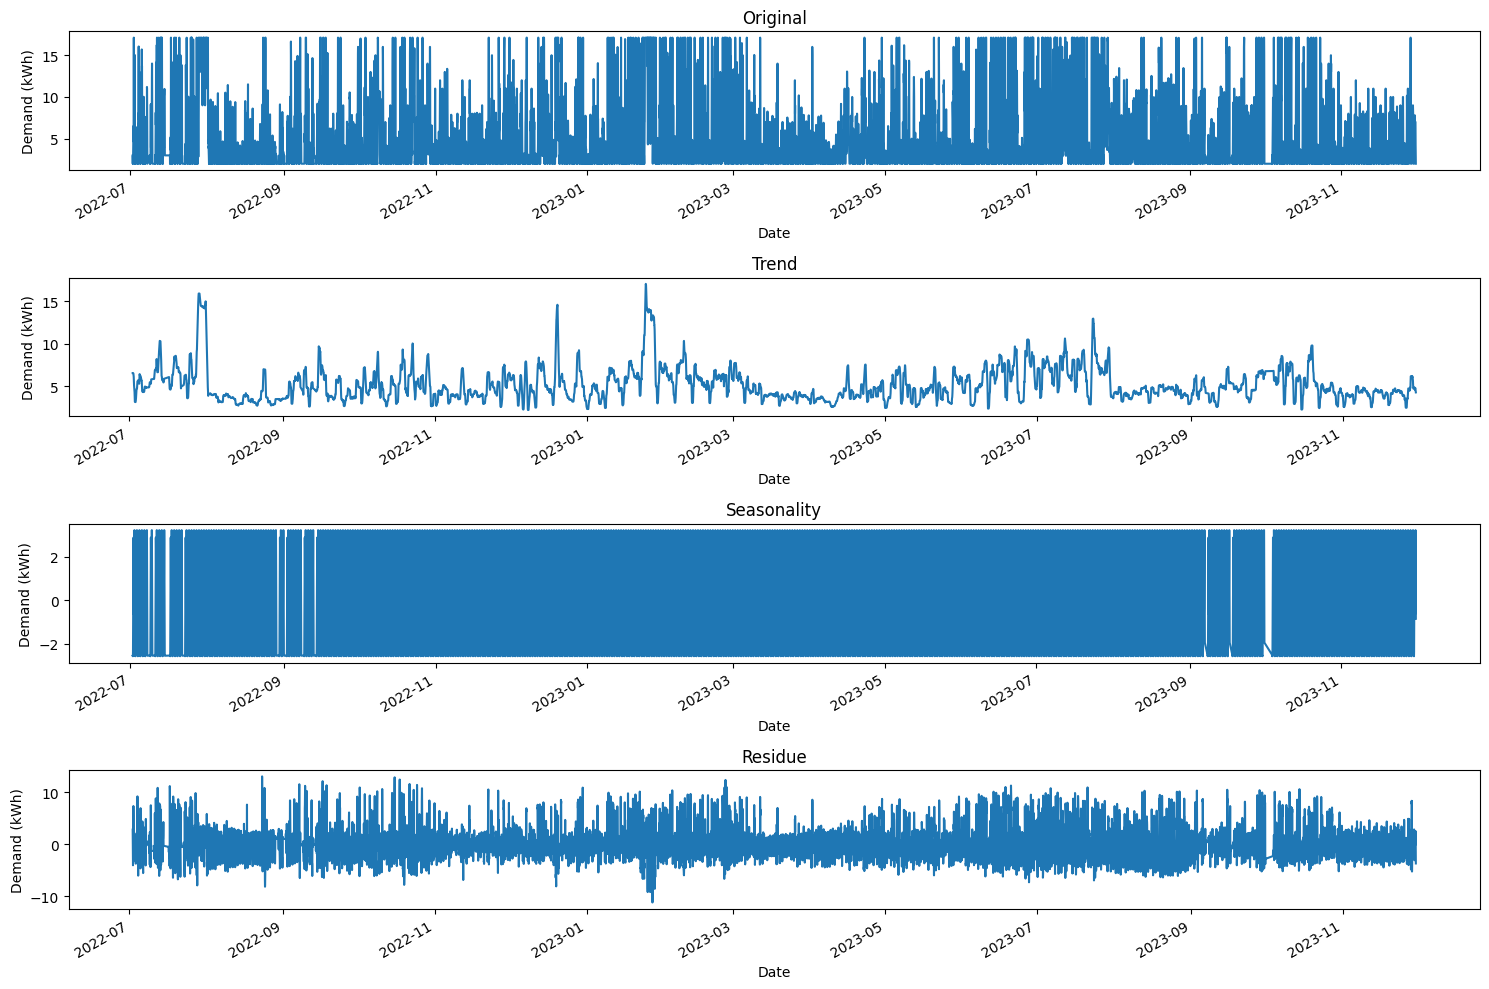

In [246]:
decomp_df = merged_df.copy(deep=True)
decomp_df.set_index("Date", inplace=True)
result = seasonal_decompose(decomp_df["Demanda_kWh"], model='additive', period=24)
decomp_df["Demanda_kWh_trend"] = result.trend
decomp_df["Demanda_kWh_seasonal"] = result.seasonal
decomp_df["Demanda_kWh_residual"] = result.resid

# Plot the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomp_df["Demanda_kWh"].plot(ax=axes[0],title="Original")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Demand (kWh)")
decomp_df["Demanda_kWh_trend"].plot(ax=axes[1], title="Trend")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Demand (kWh)")
decomp_df["Demanda_kWh_seasonal"].plot(ax=axes[2], title="Seasonality")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand (kWh)")
decomp_df["Demanda_kWh_residual"].plot(ax=axes[3], title="Residue")
axes[3].set_xlabel("Date")
axes[3].set_ylabel("Demand (kWh)")
plt.tight_layout()

plt.savefig("../results/seasonal_decompose.png", bbox_inches='tight', dpi=300)

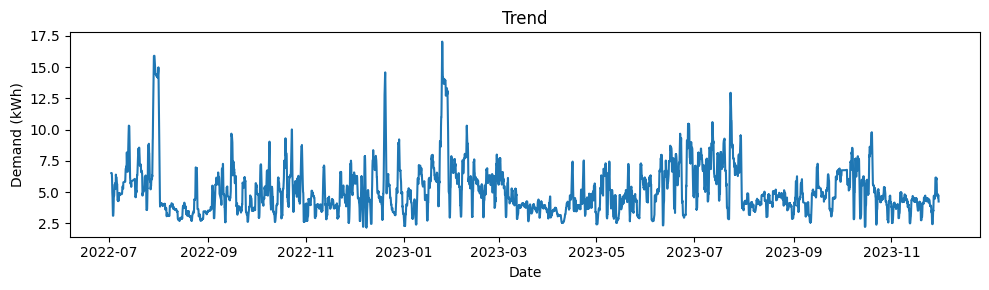

In [247]:
# Plot Trend
plt.figure(figsize=(10, 3))
plt.plot(decomp_df["Demanda_kWh_trend"])
plt.title("Trend")
plt.xlabel("Date")
plt.ylabel("Demand (kWh)")
plt.tight_layout()
plt.savefig("../results/trend.png",  bbox_inches='tight', dpi=300)
plt.show()

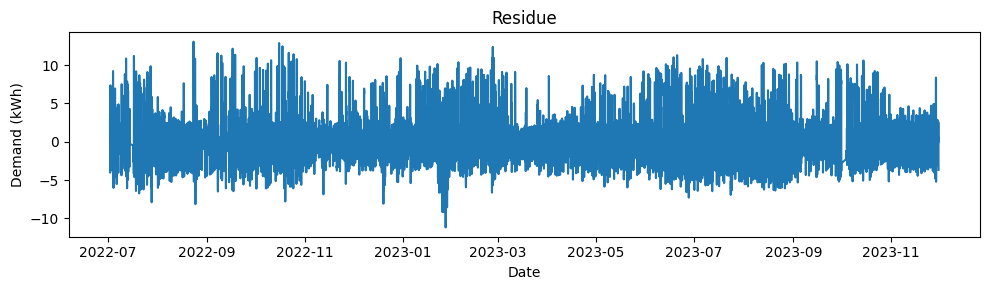

In [248]:
# Plot Residue
plt.figure(figsize=(10, 3))
plt.plot(decomp_df["Demanda_kWh_residual"])
plt.title("Residue")
plt.xlabel("Date")
plt.ylabel("Demand (kWh)")
plt.tight_layout()
plt.savefig("../results/residue.png",  bbox_inches='tight', dpi=300)
plt.show()

### Seasonality

In [249]:
df_seasonal = decomp_df["Demanda_kWh_seasonal"]
df_seasonal = df_seasonal.loc[(df_seasonal.index >= pd.to_datetime('2022-01-08 0:00', format='%Y-%d-%m %H:%M'))]
df_seasonal = df_seasonal.loc[(df_seasonal.index <= pd.to_datetime('2022-10-08 0:00', format='%Y-%d-%m %H:%M'))]
grafico_zoom(df_seasonal.index, df_seasonal.values,
              "Daily Seasonal Pattern in Demand", "", filename="estacionalidad-diaria")

### Stationarity

In [250]:
# Define the window size for the rolling mean
window_size = 24*7

# Calculate the rolling mean
decomp_df['Demand_smooth_mean'] = decomp_df['Demanda_kWh'].rolling(window=window_size).mean()
decomp_df['Demand_smooth_std'] = decomp_df['Demanda_kWh'].rolling(window=window_size).std()

trace_original = go.Scatter(
    x=decomp_df.index, 
    y=decomp_df['Demanda_kWh'], 
    mode='lines', 
    name='Original', 
    line=dict(color='gray'), 
    opacity=0.5 
)
trace_smoothed_mean = go.Scatter(
    x=decomp_df.index, 
    y=decomp_df['Demand_smooth_mean'], 
    mode='lines', 
    name='Smoothed Mean',
    line=dict(color='blue'),
    opacity= 0.8  
)
trace_smoothed_std = go.Scatter(
    x=decomp_df.index, 
    y=decomp_df['Demand_smooth_std'], 
    mode='lines', 
    name='Smoothed std',
    line=dict(color='orange'), 
    opacity=0.8   
)

# Create layout
layout = go.Layout(
    title='Mean and Standard Deviation', 
    xaxis=dict(title='Date'), 
    yaxis=dict(title='Demand [kWh]'),
    legend=dict(
        traceorder='normal',
        orientation='h',
        tracegroupgap=10 ,
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.8
    ),
    margin=dict(
        l=10,
        r=10,
        t=10,
        b=10
    )
)
# Create figure
fig = go.Figure(data=[trace_original, trace_smoothed_mean, trace_smoothed_std], layout=layout)

#Save Figure
fig.write_image("../results/smooth_mean_std.png", format="png", width=1000, scale=2)
# Show figure
fig.show()

In [251]:
result = adfuller(decomp_df["Demanda_kWh"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.573446
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### AutoCorrelation

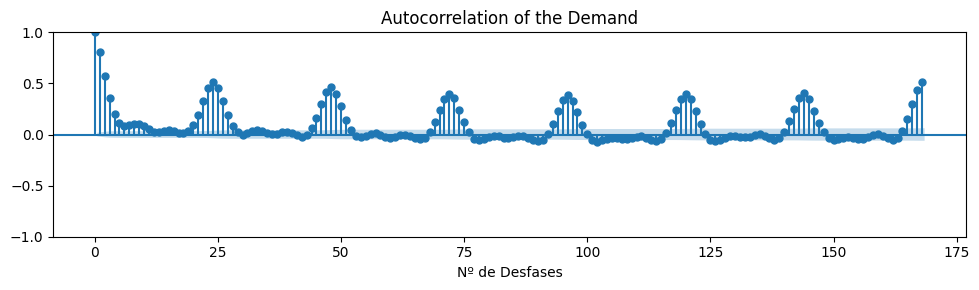

In [252]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº de Desfases")
plot_acf(merged_df["Demanda_kWh"], ax=ax, lags=24*7)
plt.title("Autocorrelation of the Demand")
plt.tight_layout()
plt.savefig("../results/autocorrelacion.png", bbox_inches='tight', dpi=300)
plt.show()

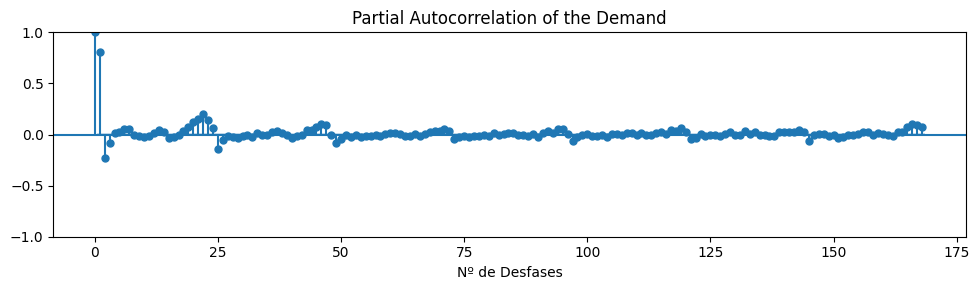

In [253]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº de Desfases")
plot_pacf(merged_df["Demanda_kWh"], ax=ax, lags=24*7)
plt.title("Partial Autocorrelation of the Demand")
plt.tight_layout()
plt.savefig("../results/autocorrelacion_parcial.png", bbox_inches='tight', dpi=300)
plt.show()

## Exogenous Variables

In [254]:
# Fields extracted directly from the Date
merged_df["Year"] = merged_df["Date"].dt.year
merged_df["Month"] = merged_df["Date"].dt.month
merged_df["Hour"] = merged_df["Date"].dt.hour
merged_df["DayOfWeek"] = merged_df["Date"].dt.day_of_week
merged_df["DayOfYear"] = merged_df["Date"].dt.day_of_year
merged_df["Day"] = merged_df["Date"].dt.day

In [255]:
merged_df

Date  temperature_2m_C  relative_humidity_2m_%  \
4368  2022-07-02 00:00:00         20.259000               84.817234   
4369  2022-07-02 01:00:00         19.277750               89.401823   
4370  2022-07-02 02:00:00         19.715250               88.562090   
4371  2022-07-02 03:00:00         19.759000               88.008093   
4372  2022-07-02 04:00:00         19.609001               88.203276   
...                   ...               ...                     ...   
16771 2023-11-30 19:00:00         17.527750               79.080132   
16772 2023-11-30 20:00:00         17.577750               78.784395   
16773 2023-11-30 21:00:00         18.015251               75.550207   
16774 2023-11-30 22:00:00         18.209001               74.234406   
16775 2023-11-30 23:00:00         18.234001               74.540789   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
4368        17.602751               22.359378       1020.012512   
4369        17.490251               21.180619       1019.587524   
4370        17.771502               21.657682       1019.212524   
4371        17.715251               21.494984       1018.787506   
4372        17.602750               21.462321       1018.562485   
...               ...                     ...               ...   
16771       13.859000               15.473409       1002.727979   
16772       13.846500               15.383718       1002.727979   
16773       13.627749               15.511757       1002.727979   
16774       13.546500               15.470847       1002.727979   
16775       13.634000               15.359568       1002.727979   

       surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
4368            1014.212769       0.562500               0.000   
4369            1013.770798       0.000000               0.000   
4370            1013.406601       0.000000               0.000   
4371            1012.984924       0.000000               0.000   
4372            1012.758133       4.837500              16.125   
...                     ...            ...                 ...   
16771            996.874541      26.625001              85.000   
16772            996.874541      23.250002              76.750   
16773            996.874541      14.025001              44.000   
16774            996.874541      18.075001              55.875   
16775            996.874541      19.987500              60.125   

       et0_fao_evapotranspiration_mm  ...  global_tilted_irradiance_W/m2  \
4368                        0.000000  ...                           0.00   
4369                        0.000000  ...                           0.00   
4370                        0.000000  ...                           0.00   
4371                        0.000000  ...                           0.00   
4372                        0.006310  ...                           3.75   
...                              ...  ...                            ...   
16771                       0.043323  ...                           0.00   
16772                       0.046048  ...                           0.00   
16773                       0.059088  ...                           0.00   
16774                       0.066204  ...                           0.00   
16775                       0.067577  ...                           0.00   

       terrestrial_radiation_W/m2  Temp_interna_Modulo_C  Demanda_kWh  Year  \
4368                      0.00000              26.384071     3.000000  2022   
4369                      0.00000              25.940834     2.000000  2022   
4370                      0.00000              26.138456     3.000000  2022   
4371                      0.00000              26.158218     2.000000  2022   
4372                     18.89632              26.297756     3.055266  2022   
...                           ...                    ...          ...   ...   
16771                     0.00000              25.150345     6.000000  2023   
16772                    

In [256]:
#Sine and Cosine Transformations
def cyclical_encoding(df, cycle_length_list, columns):
    for col, cycle_length in zip(columns, cycle_length_list):
        if df[col].min == 0:
            df[f"{col}_sin"] = np.sin((df[col] / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos((df[col] / cycle_length) * np.pi * 2).round(4)
        else:
            df[f"{col}_sin"] = np.sin(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
    return df

#Add isWeekend Column based in DayOfTheWeek Value
merged_df["isWeekend"] = merged_df["DayOfWeek"].isin([5, 6])
cycle_lengths = [24, 7, 12, 365]
cols = ["Hour", "DayOfWeek", "Month", "DayOfYear"]

#Encode cyclical fields using sin/cos transformation
merged_df = cyclical_encoding(merged_df, cycle_lengths, cols)

merged_df.head(3)

Date  temperature_2m_C  relative_humidity_2m_%  \
4368 2022-07-02 00:00:00          20.25900               84.817234   
4369 2022-07-02 01:00:00          19.27775               89.401823   
4370 2022-07-02 02:00:00          19.71525               88.562090   

      dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
4368       17.602751               22.359378       1020.012512   
4369       17.490251               21.180619       1019.587524   
4370       17.771502               21.657682       1019.212524   

      surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
4368           1014.212769         0.5625                 0.0   
4369           1013.770798         0.0000                 0.0   
4370           1013.406601         0.0000                 0.0   

      et0_fao_evapotranspiration_mm  ...  Day  isWeekend  Hour_sin  Hour_cos  \
4368                            0.0  ...    2       True   -0.2588    0.9659   
4369                            0.0  ...    2       True    0.0000    1.0000   
4370                            0.0  ...    2       True    0.2588    0.9659   

      DayOfWeek_sin  DayOfWeek_cos  Month_sin  Month_cos  DayOfYear_sin  \
4368        -0.4339         -0.901        0.0       -1.0         0.0086   
4369        -0.4339         -0.901        0.0       -1.0         0.0086   
4370        -0.4339         -0.901        0.0       -1.0         0.0086   

      DayOfYear_cos  
4368           -1.0  
4369           -1.0  
4370           -1.0  

[3 rows x 39 columns]

In [257]:
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df

merged_df = generateHolidayVar(merged_df)

In [258]:
nan_rows = merged_df['temperature_2m_C'].isna().sum()
nan_rows

0

In [259]:
grafico_zoom(merged_df["Date"], merged_df["Demanda_kWh"],
              "Bounded Electricity Demand Dataset", "Demand [kWh]", filename="curva_demanda_acotada")

In [260]:
def createClusters(df):
    cluster_df = df.copy(deep=True)
    cluster_df.set_index("Date", inplace=True)
    cluster_df = cluster_df[["temperature_2m_C"]]
    cluster_df = cluster_df.resample('1D').mean()
    cluster_df = cluster_df.dropna()
    cluster_df.reset_index(inplace=True)
    scaler = MinMaxScaler()
    cluster_df['temp_sta'] = scaler.fit_transform(cluster_df[["temperature_2m_C"]])
    dist_matrix = pdist(cluster_df[['temp_sta']], metric='euclidean')
    linked = linkage(dist_matrix, method="centroid")
    cluster_df['temp_cluster'] = fcluster(linked, 3, criterion='maxclust')

    #Gráfico del valor de la variable cluster
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=cluster_df.Date, y=cluster_df["temp_cluster"], mode='lines'))
    fig.update_layout(
        title = "Clusters de Temperaturas por Fechas",
        xaxis_title = "Fecha",
        yaxis_title = "Cluster de Temperatura",
        width = 850,
        height = 400,
        margin=dict(l=20, r=20, t=35, b=20),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1,
            xanchor="left",
            x=0.001
        )
    )
    fig.show()
    return cluster_df

cluster_df = createClusters(merged_df)

In [261]:
cluster_df.set_index("Date", inplace=True)
cluster_df = cluster_df.resample('15T').ffill().reset_index()
merged_df = merged_df.merge(cluster_df[["Date", "temp_cluster"]], on="Date", how='inner')
merged_df.reset_index(inplace=True, drop=True)

## Other Plots

### Demand Distribution per Hour of the Day

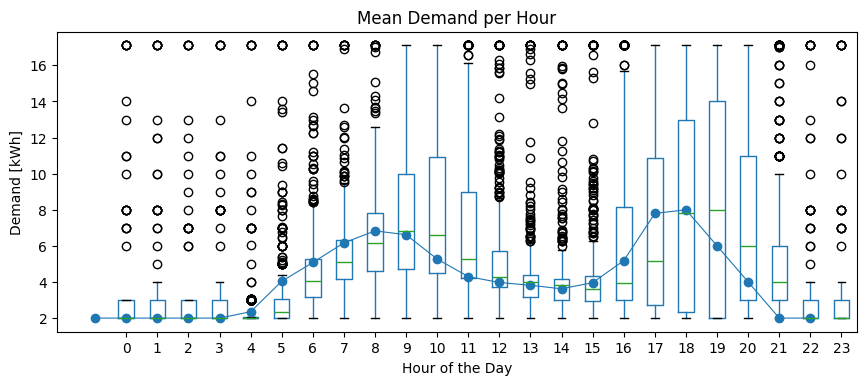

In [262]:
fig, ax = plt.subplots(figsize=(10, 4))
merged_df.boxplot(column='Demanda_kWh', by='Hour', ax=ax)
merged_df.groupby('Hour')['Demanda_kWh'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand [kWh]')
ax.set_xlabel('Hour of the Day')
ax.set_title("Mean Demand per Hour")
fig.suptitle('')
plt.savefig("../results/demanda_hora.png", bbox_inches='tight', dpi=300)

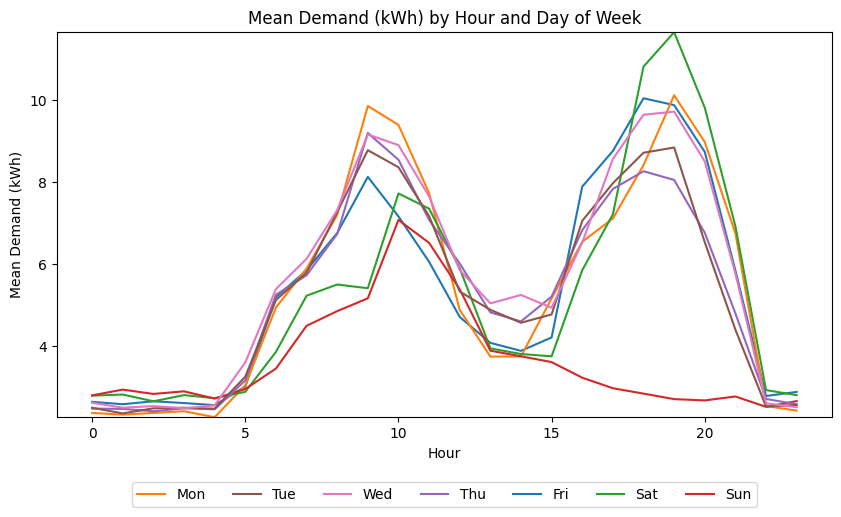

In [263]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
merged_df["Day"] = merged_df["DayOfWeek"].map(days_mapping)
grouped = merged_df.groupby([merged_df['Hour'], merged_df['Day']])['Demanda_kWh'].mean().unstack()

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

ymin, ymax = grouped.min().min(), grouped.max().max()
grouped.plot(ax=axes, ylim=(ymin, ymax), title="", legend=True)

# LEGEND
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ordered_handles = [handles[labels.index(day)] for day in order]
axes.legend(ordered_handles, order, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7, frameon=True)
plt.xlabel('Hour')
plt.ylabel('Mean Demand (kWh)')
plt.title('Mean Demand (kWh) by Hour and Day of Week')
plt.show()

In [264]:
start_date = merged_df.Date.min() + timedelta(days=62)
end_date = start_date + timedelta(days=31)
df_month1 = merged_df.loc[(merged_df.Date >= start_date) & (merged_df.Date <= end_date)]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_month1.Date, y=df_month1["Demanda_kWh"], mode='lines'))
fig.update_layout(
    title = "One Month Demand",
    xaxis_title = "Date",
    yaxis_title = "Demand (kWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### Demand Distribution per Month

Text(0.5, 0.98, '')

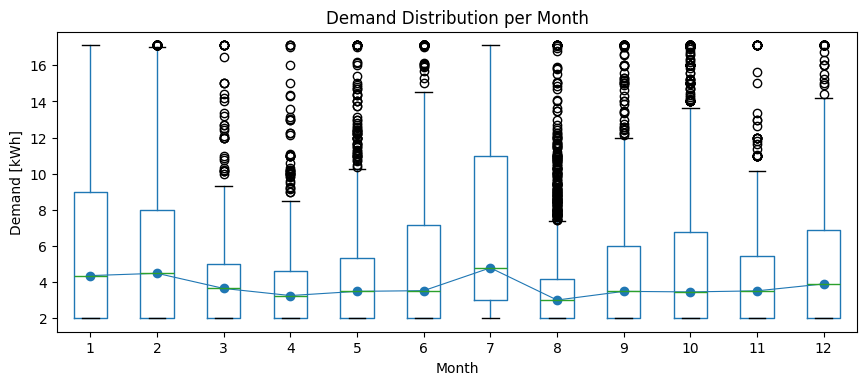

In [265]:
fig, ax = plt.subplots(figsize=(10, 4))
merged_df.boxplot(column='Demanda_kWh', by='Month', ax=ax)
merged_df.groupby('Month')['Demanda_kWh'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand [kWh]')
ax.set_title("Demand Distribution per Month")
fig.suptitle('')

### Month to Month Demand

In [266]:
def plot_monthly_Demand(dataframe, filename):
    df = dataframe.copy(deep=True)
    df.set_index("Date", inplace=True)

    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    groups = df.groupby([df.index.year, df.index.month])
    fig = make_subplots(rows=6, cols=2, subplot_titles=[calendar.month_name[i] for i in range(1, 13)], horizontal_spacing=0.1, vertical_spacing=0.05)
    colors = ['blue', 'orange', 'green']

    for month in range(1, 13):
        row = (month - 1) // 2 + 1
        col = (month - 1) % 2 + 1
        monthly_data = df[df.index.month == month]
        unique_years = monthly_data.index.year.unique()
        for i, year in enumerate(unique_years):
            year_data = monthly_data[monthly_data.index.year == year]
            year_data = year_data.copy(deep=True)
            year_data.index = year_data.index.map(lambda x: x.replace(year=2022))  # Normalizar el año para superponer curvas
            fig.add_trace(
                go.Scatter(x=year_data.index, y=year_data["Demanda_kWh"], mode='lines', name=f"{year}",
                           legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=False),
                row=row, col=col
            )
        fig.update_xaxes(title_text="Date", row=row, col=col)
        fig.update_yaxes(title_text="Demand (kWh)", row=row, col=col)
    unique_years = df.index.year.unique()
    for i, year in enumerate(unique_years):
                fig.add_trace(
                    go.Scatter(x=[None], y=[None], mode='lines', name=f"{year}",
                            legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=True),
                    row=row, col=col
                )
    fig.update_layout(
        title = {
            "text": "Month to Month Demand",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title="Date",
        yaxis_title="Demand (kWh)",
        width=1200,
        height=2000,
        margin=dict(l=20, r=20, t=45, b=20)   
    )
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", scale=2, format="png")
    fig.show()
plot_monthly_Demand(merged_df, "demand_per_month")

### Demand per Hour, Day and Season

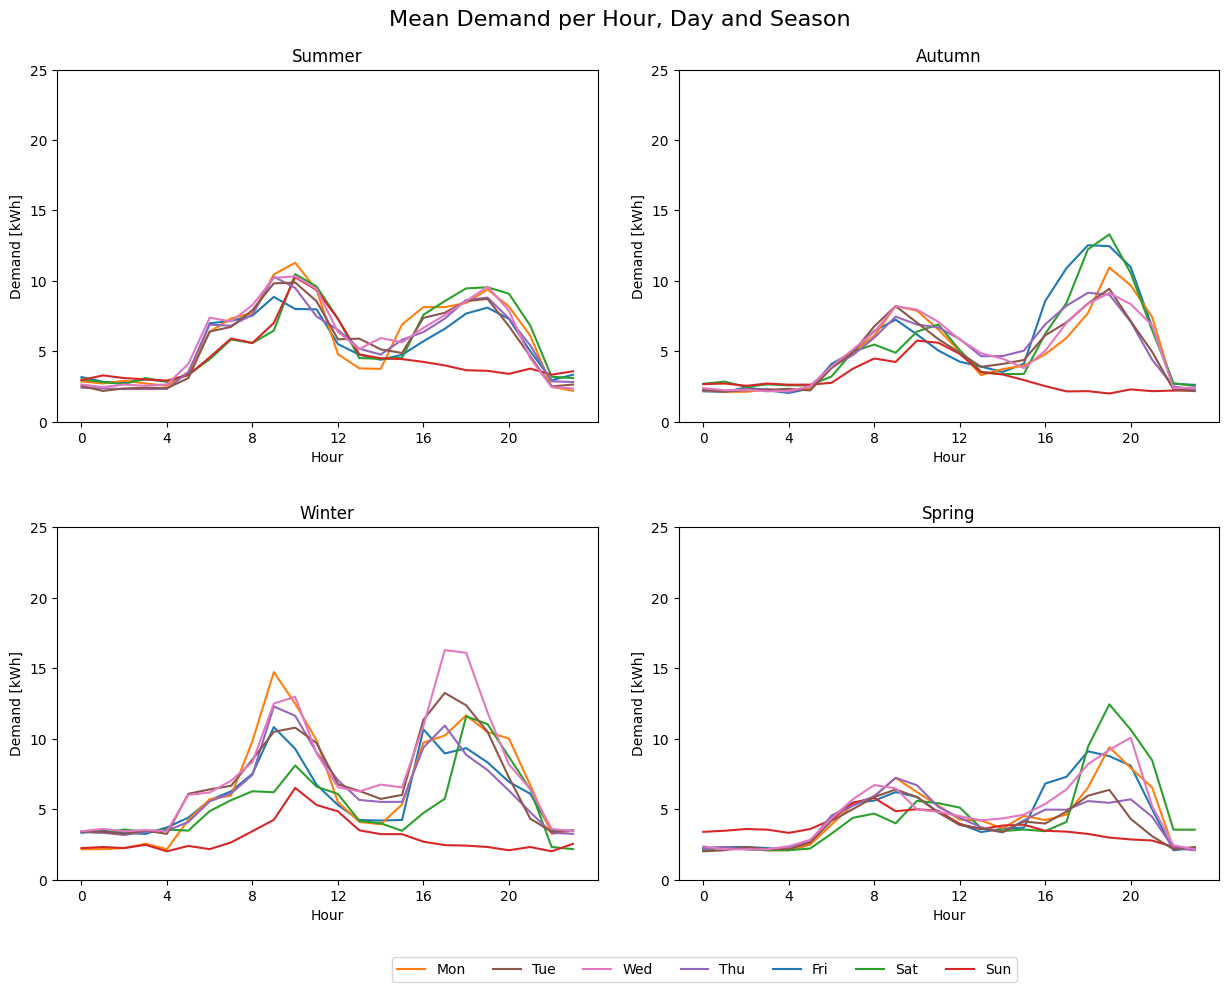

In [267]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
merged_df["Day"] = merged_df["DayOfWeek"].map(days_mapping)
merged_df["Season"] = merged_df["Month"].apply(
    lambda x: (
        1 if x in [3, 4, 5] #Spring
        else 2 if x in [6, 7, 8] #Summer
        else 3 if x in [9, 10, 11] #Autumn
        else 0 #Winter
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.15, hspace=0.3, top=0.92)
fig.suptitle("Mean Demand per Hour, Day and Season", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 25

#Season Summer
merged_df.loc[merged_df["Season"] == 2] \
    .groupby([merged_df.loc[merged_df["Season"] == 2]["Hour"], 'Day'])["Demanda_kWh"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Summer", legend=False
    )
merged_df.loc[merged_df["Season"] == 3] \
    .groupby([merged_df.loc[merged_df["Season"] == 3]["Hour"], 'Day'])["Demanda_kWh"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Autumn", legend=False
    )
merged_df.loc[merged_df["Season"] == 0] \
    .groupby([merged_df.loc[merged_df["Season"] == 0]["Hour"], 'Day'])["Demanda_kWh"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Winter", legend=False
    )
merged_df.loc[merged_df["Season"] == 1] \
    .groupby([merged_df.loc[merged_df["Season"] == 1]["Hour"], 'Day'])["Demanda_kWh"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Spring", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='Hour', ylabel='Demand [kWh]')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])
merged_df = merged_df.drop("Day", axis=1)
# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND

plt.savefig("../results/demanda_estacion.png", bbox_inches='tight', dpi=300)

In [268]:
merged_df[["Demanda_kWh"]].describe()

Demanda_kWh
count  12046.000000
mean       5.142404
std        4.108301
min        2.000000
25%        2.000000
50%        3.591237
75%        6.163178
max       17.108163

### Relationship between Demand and Temperature. 

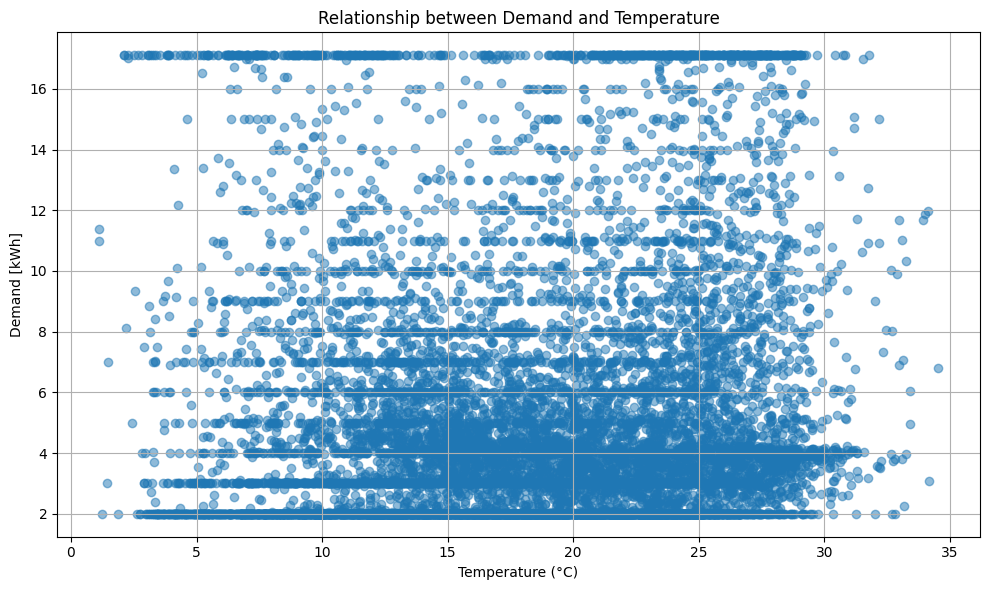

In [269]:

def plot_temp_vs_demand(df):
    df = df.copy(deep=True)
    df.set_index("Date", inplace=True)
    plt.figure(figsize=(10, 6))
    plt.scatter(df['temperature_2m_C'], df['Demanda_kWh'], alpha=0.5)
    plt.title('Relationship between Demand and Temperature')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Demand [kWh]')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../results/scatterplot_demanda_temp.png", bbox_inches='tight', dpi=300)
    plt.show()
plot_temp_vs_demand(merged_df)

### Correlation Matrix (Lollipop Chart)

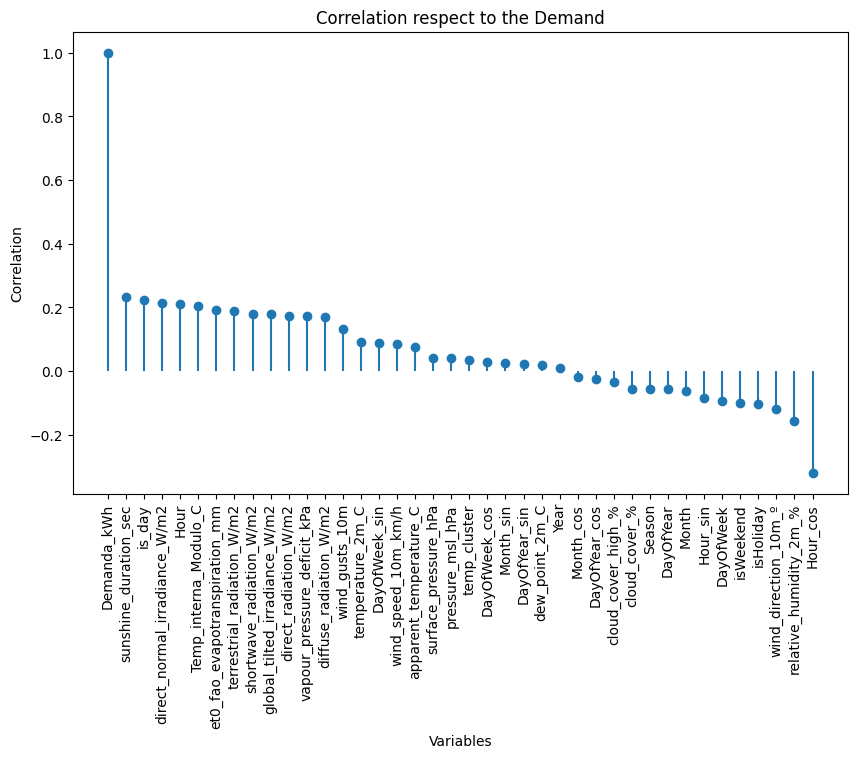

In [270]:
merged_df.set_index("Date", inplace=True)
correlation_matrix = merged_df.corr()
merged_df.reset_index(inplace=True)
sorted_correlation = correlation_matrix.sort_values(by='Demanda_kWh', ascending=False)

# Crear un gráfico lollipop de la correlación respecto a la variable específica
plt.figure(figsize=(10, 6))
plt.stem(sorted_correlation.index, sorted_correlation['Demanda_kWh'], basefmt=" ")
plt.title('Correlation respect to the Demand')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

In [271]:
merged_df

Date  temperature_2m_C  relative_humidity_2m_%  \
0     2022-07-02 00:00:00         20.259000               84.817234   
1     2022-07-02 01:00:00         19.277750               89.401823   
2     2022-07-02 02:00:00         19.715250               88.562090   
3     2022-07-02 03:00:00         19.759000               88.008093   
4     2022-07-02 04:00:00         19.609001               88.203276   
...                   ...               ...                     ...   
12041 2023-11-29 20:00:00         11.190250               92.669918   
12042 2023-11-29 21:00:00         11.140250               90.235245   
12043 2023-11-29 22:00:00         11.609000               87.170971   
12044 2023-11-29 23:00:00         12.221500               85.602179   
12045 2023-11-30 00:00:00         12.815249               84.771992   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
0           17.602751               22.359378       1020.012512   
1           17.490251               21.180619       1019.587524   
2           17.771502               21.657682       1019.212524   
3           17.715251               21.494984       1018.787506   
4           17.602750               21.462321       1018.562485   
...               ...                     ...               ...   
12041       10.046500               10.525317       1004.975006   
12042        9.596500               10.341212       1004.487473   
12043        9.546500               10.604668       1004.299988   
12044        9.877750               10.940205       1004.187500   
12045       10.315249               11.358766       1003.887497   

       surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
0               1014.212769       0.562500               0.000   
1               1013.770798       0.000000               0.000   
2               1013.406601       0.000000               0.000   
3               1012.984924       0.000000               0.000   
4               1012.758133       4.837500              16.125   
...                     ...            ...                 ...   
12041            999.079224      29.550002              97.000   
12042            998.593491      29.475001              93.500   
12043            998.416656      24.637501              76.125   
12044            998.317459      22.012500              64.375   
12045            998.031494      34.650001             100.000   

       et0_fao_evapotranspiration_mm  ...  Hour_cos  DayOfWeek_sin  \
0                           0.000000  ...    0.9659        -0.4339   
1                           0.000000  ...    1.0000        -0.4339   
2                           0.000000  ...    0.9659        -0.4339   
3                           0.000000  ...    0.8660        -0.4339   
4                           0.006310  ...    0.7071        -0.4339   
...                              ...  ...       ...            ...   
12041                       0.000000  ...    0.2588         0.7818   
12042                       0.000000  ...    0.5000         0.7818   
12043                       0.000000  ...    0.7071         0.7818   
12044                       0.001806  ...    0.8660         0.7818   
12045                       0.005335  ...    0.9659         0.9749   

       DayOfWeek_cos  Month_sin  Month_cos  DayOfYear_sin  DayOfYear_cos  \
0            -0.9010      0.000       -1.0         0.0086        -1.0000   
1            -0.9010      0.000       -1.0         0.0086        -1.0000   
2            -0.9010      0.000       -1.0         0.0086        -1.0000   
3            -0.9010      0.000       -1.0         0.0086        -1.0000   
4            -0.9010      0.000       -1.0         0.0086        -1.0000   
...              ...        ...        ...            ...            ...   
12041         0.6235     -0.866        0.5        -0.5380         0.8429   
12042         0.6235     -0.866        0.5        -0.5380         0.8429   
12043         0.6235     -0.866        0.5   

## Save Dataset

In [272]:
# Save the Dataframe into a csv
nombre_archivo = "LaMonserratina_CLEAN.csv"
merged_df.to_csv("../data/data_casal_montserratina/LaMonserratina_CLEAN.csv", index=False)